# Introduction


**What?** Early stopping (avoid overfitting)



# What is early stopping?


- Early stopping is an approach to training complex machine learning models to avoid overfitting. 
- It works by monitoring the performance of the model that is being trained on a separate test dataset and stopping the training procedure once the performance on the test dataset has not improved after a fixed number of training iterations.



# Import modules

In [1]:
from pylab import rcParams
from numpy import loadtxt
from pylab import rcParams
from matplotlib import pyplot
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split

# Load dataset

In [2]:
# load data
dataset = loadtxt('../DATASETS/pima-indians-diabetes.csv', delimiter = ",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]

# Fit the model for different evaluation metrics


- Some of the options are:
    - logloss
    - rmse for root mean squared error.
    - mae for mean absolute error.
- In this case we'll try them all to see how the differ.



In [3]:
# Split data into train and test sets (an alternative could be k-fold)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7) 

# Fit model on training data
model = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]


# Model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose = True)
model.fit(X_train, y_train, eval_metric = ["error", "logloss", "mae", "rmse"], eval_set=eval_set, verbose=False)

# Make predictions for test data
predictions = model.predict(X_test)

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.95%


# Does evaluating different metrics increase the training time?


- It seems it is not affecting much the training time. 
- In fact, the model fitting is the same, we are just changing the way we measured the performance!
- That is an important point that is often **missed**. Every machine learnign model will reduce the error wrt a specific error. However, tracking this error is sometimes not informative at all. This is the main reason why people uses an evaluation metric that is different from the one actually being driven to zero.



In [4]:
model1 = XGBClassifier()

In [5]:
%%time
model1.fit(X_train, y_train, eval_metric = ["error", "logloss", "mae", "rmse"], eval_set=eval_set, verbose=False)

CPU times: user 69.2 ms, sys: 3.97 ms, total: 73.1 ms
Wall time: 72.3 ms


XGBClassifier()

In [6]:
%%time
model1.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose = False)

CPU times: user 67.5 ms, sys: 3.92 ms, total: 71.4 ms
Wall time: 71.4 ms


XGBClassifier()

# Plot training history for different evaluation metrics


-  eval_set = [(X_train, y_train), (X_test, y_test)]
- **validation_0** correspond to the first set provided in the list above



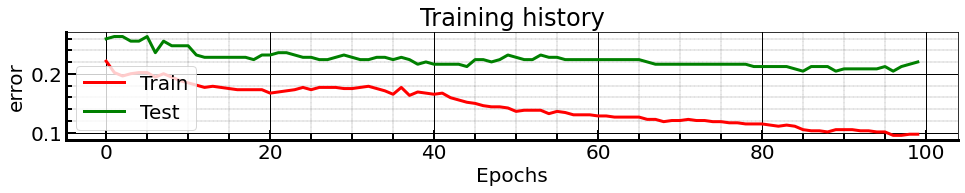

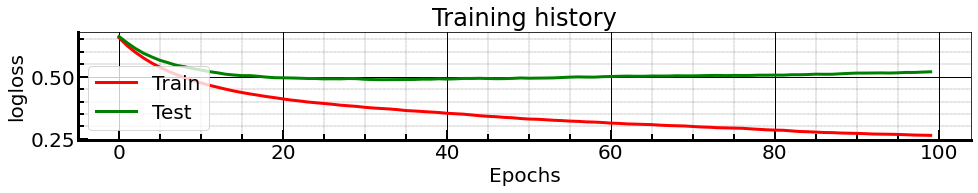

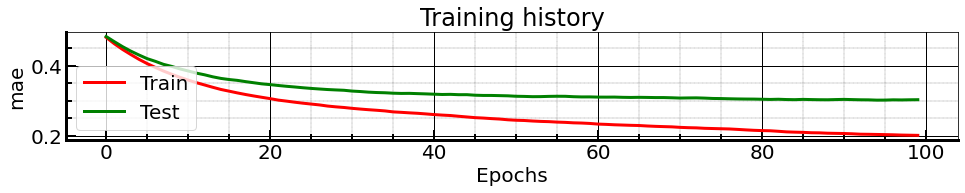

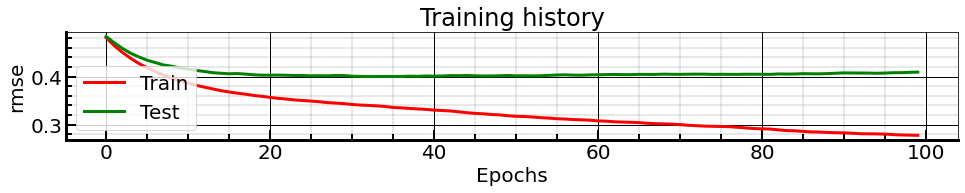

In [7]:
# Retrieve performance metrics
results = model.evals_result()

epochs = len(results['validation_0']['error']) 
x_axis = range(0, epochs)

rcParams['figure.figsize'] = 16, 2
rcParams['font.size'] = 20

for currentMetric in ["error", "logloss", "mae", "rmse"]:

    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0'][currentMetric], 'r-', lw = 3, label = 'Train') 
    ax.plot(x_axis, results['validation_1'][currentMetric], 'g', lw = 3, label = 'Test') 
    ax.legend() 
    pyplot.xlabel('Epochs')
    pyplot.ylabel(currentMetric)
    pyplot.title('Training history')

    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.minorticks_on()
    pyplot.show()


- Some of them clearly show a change in trend, some are less obvious. 
- We are particularly interested where there is a minimum and the generalisation gap **start to increase**.
- The **generalisation gap** is the difference betwen the training and test curves. 



# Fixed iteration vs. early stopping


-  Further we see that there is a possibility for the training to be stiopped earlier. This can be done via a technique called **early stopping**.
- For this technique to work you see that you need to specified the evaluation metric, **but which one?** 
- The study reported above should help us choose it. 
- Nevertheless we'll try them all in a loop. 
- You must specify a window of the number of epochs over which no improvement is observed. 
- This is specified in the early stopping rounds parameter. 
- For example, we can check for no improvement in logarithmic loss over the 10 epochs
 -In some cases the improvement was in the region of 2% which is **NOT** small.



In [8]:
for currentEvaluationMetric in ["error", "logloss", "mae", "rmse"]:

    print("")
    print("Evaluation metrics: ", currentEvaluationMetric)
    
    # Fit model on training data with early stopping
    model = XGBClassifier()
    eval_set = [(X_test, y_test)]
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric = currentEvaluationMetric,
        eval_set=eval_set, verbose = False)    
    # make predictions for test data
    predictions = model.predict(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy [with early stopping]: %.2f%%" % (accuracy * 100.0))

    # Fit model on training data with NO early stopping
    model = XGBClassifier()
    model.fit(X_train, y_train, eval_metric = currentEvaluationMetric, eval_set=eval_set, verbose=False)
    # make predictions for test data 
    predictions1 = model.predict(X_test)
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions1)
    print("Accuracy [with no early stopping]: %.2f%%" % (accuracy * 100.0))


Evaluation metrics:  error
Accuracy [with early stopping]: 77.56%
Accuracy [with no early stopping]: 77.95%

Evaluation metrics:  logloss
Accuracy [with early stopping]: 77.56%
Accuracy [with no early stopping]: 77.95%

Evaluation metrics:  mae
Accuracy [with early stopping]: 79.13%
Accuracy [with no early stopping]: 77.95%

Evaluation metrics:  rmse
Accuracy [with early stopping]: 77.56%
Accuracy [with no early stopping]: 77.95%


# Conclusions


- There are many evaluation metrics available.
- The one used depends on whether you are solving and regression or classification problem.
- It is important for you to know which metric is most imformative for the business you are in or the problem you are solving.



# References


- https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

